# STANDALONE STUDY
## **DOUBLE WISHBONE DIRECT ACTING**
------------------------------------

## Environment Setup
--------------------

### Colab Session
*Run if in a Colab Session Only!*

#### Setting-up Colab Virtual Machine
This will clone the package repository and install the needed modules into the Virtual Machine dedicated for the running notebook session.

In [ ]:
!git clone https://github.com/khaledghobashy/smbd.git
!pip install sympy==1.4

import os
import sys

pkg_path = '/content/smbd'
sys.path.append(pkg_path)

os.mkdir('smbd_project')
os.chdir('smbd_project')

#### Rendering SymPy in Colab
Rendering SymPy equations in Colab requires the MathJax javascript library to be available within each cell output. The following defines an execution hook that loads it automatically each time you execute a cell.

In [ ]:
from IPython.display import Math, HTML

def load_mathjax_in_cell_output():
  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
               "mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

---------------------------------------------------------------

### Local Session
*Run if on your Local Machine!*</br>

The ```pkg_path``` variable is where you have the repository on your machine and should be changed to where you cloned the repository.</br>
*Uncomment the code below and change the ```pkg_path``` variable!*

In [1]:
#import sys
#pkg_path = '/path/to/smbd'
#sys.path.append(pkg_path)

---------------------------------------------------------------
---------------------------------------------------------------

Creating Project Directory

In [2]:
from smbd.systems import standalone_project

In [3]:
project = standalone_project()
project.create()

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM DESCRIPTION**
-------------------------

### **Important Note**
The tool uses [euler-parameters](https://en.wikibooks.org/wiki/Multibody_Mechanics/Euler_Parameters) -which is a 4D unit quaternion- to represents bodies orientation in space. This makes the generalized coordinates used to fully define a body in space to be **7,** instead of **6**, it also adds an algebraic equation to the constraints that ensures the unity/normalization of the body quaternion. This is an important remark as the calculations of the degrees-of-freedom depends on it.

### **Summary**

A **double wishbone** mechanism is a type of  independent suspension mechanism used for automotive. It controls the motion of the wheel assembly via two control arms that are connected to the chassis from one end and to the wheel-carrier on the other end, which resembles a **four-bar linkage**, with the chassis being the ground, and the wheel-carrier being the coupler. The wheel-carrier is connected also to the chassis via a tie-rod that constrains the steering of the wheel-assembly as well. 

This kinematic chain is augmented with a another simple chain that controls the vertical motion of the wheel-assembly, this simple chain can be a direct-acting coil-over that is connected to either one of the control arms and the chassis, or can be a rocker-push/pull rod mechanism that is connected to the coil-over.

![Figure 1 - System Layout](double_wishbone.png)

*Figure 1 - Double Wishbone Layout*

### **Topology Layout**

The mechanism consists of 8 Bodies + 1 Ground. Therefore, total system coordinates -including the ground- is $$n=n_b\times7 = 9\times7 = 63$$ 
where $n_b$ is the total number of bodies. The list of bodies is given below:

- Upper Control Arm **(UCA)**.
- Lower Control Arm **(LCA)**.
- Upright.
- Wheel Hub.
- Tie-Rod.
- CoilOver P1.
- CoilOver P2.
- Steering Rack.

The system connectivity is given in the table below.

</br>

| Joint Name      | Body i        | Body j      | Joint Type    | $n_c$ |
|:--------------- |:------------- |:----------- | :----------:  | ----: |
| UCA Outer Joint | UCA           | Upright     | Spherical     | 3     |
| LCA Outer Joint | LCA           | Upright     | Spherical     | 3     |
| Tie-Rod Outer   | Tie-Rod       | Upright     | Spherical     | 3     |
| UCA-Chassis     | UCA           | Chassis     | Revolute      | 5     |
| LCA-Chassis     | LCA           | Chassis     | Revolute      | 5     |
| Hub Bearing     | Wheel-Hub     | Upright     | Revolute      | 5     |
| Tie-Rod Inner   | Tie-Rod       | Chassis     | Universal     | 4     |
| CoilOver Top    | CoilOver P1   | Chassis     | Universal     | 4     |
| CoilOver Bottom | CoilOver P2   | UCA         | Universal     | 4     |
| CoilOver Cyl    | CoilOver P1   | CoilOver P2 | Cylinderical  | 4     |
| Rack-Chassis    | Steering Rack | Chassis     | Translational | 5     |
| **Total**       | ------------- | ----------- | ------------- | 45    |

</br>

Hence, the total number of constraints equations is:
$$ n_{c} = n_{c_j} + n_{c_p} + n_{c_g} = 45 + (9\times 1) + 6 = 60 $$

where:
* $n_{c_j}$ is the joints constraints.
* $n_{c_p}$ is the euler-parameters normalization constraints.
* $n_{c_g}$ is the ground constraints.

Therefore, the resulting **DOF** is:
$$ n - n_c = 63 - 60 = 3 $$

which can be interpreted in a convenient way that one DOF is the rotational motion of the wheel, one is the vertical motion and one for the rack travel.

</br>

-----
-----

## **SYMBOLIC TOPOLOGY**
------------------------

In this section, we create the symbolic topology that captures the topological layout that we just discussed.</br>
Defining the topology is very simple. We start by creating an instance of the ```standalone_topology``` class that represents our symbolic model. Then we start adding the components we discussed earlier, starting by the bodies, then the joints, actuators and forces, and thats it.</br>
These components will be represented symbolically, and therefore there is no need for any numerical inputs at this step.

The system is stored in a form of a network graph that stores all the data needed for the assemblage of the system equations later. But even before the assemblage process, we can gain helpful insights about our system as well be shown.


In [4]:
from smbd.systems import standalone_topology, configuration

In [5]:
project_name = 'dwb_direct_acting'

In [6]:
sym_model = standalone_topology(project_name)

### Adding Bodies

In [7]:
# Adding Bodies
# =============
sym_model.add_body('uca', mirror=True)
sym_model.add_body('lca', mirror=True)
sym_model.add_body('upright', mirror=True)
sym_model.add_body('upper_strut', mirror=True)
sym_model.add_body('lower_strut' ,mirror=True)
sym_model.add_body('tie_rod', mirror=True)
sym_model.add_body('hub', mirror=True)
sym_model.add_body('steer_rack')


### Adding Joints

In [8]:
# Adding Joints
# =============

# Upper Control Arm Joints
sym_model.add_joint.spherical('uca_upright', 'rbr_uca', 'rbr_upright', mirror=True)
sym_model.add_joint.revolute('uca_chassis', 'rbr_uca', 'ground', mirror=True)

# Lower Control Arm Joints
sym_model.add_joint.spherical('lca_upright', 'rbr_lca', 'rbr_upright', mirror=True)
sym_model.add_joint.revolute('lca_chassis', 'rbr_lca', 'ground', mirror=True)

# Tie-Rod Joints
sym_model.add_joint.spherical('tie_upright', 'rbr_tie_rod', 'rbr_upright', mirror=True)
sym_model.add_joint.universal('tie_steering', 'rbr_tie_rod', 'rbs_steer_rack', mirror=True)

# Hub Bearing Joint
sym_model.add_joint.revolute('hub_bearing', 'rbr_upright', 'rbr_hub', mirror=True)

# Strut/Coilover Joints
sym_model.add_joint.universal('strut_chassis', 'rbr_upper_strut', 'ground', mirror=True)
sym_model.add_joint.universal('strut_uca', 'rbr_lower_strut', 'rbr_uca', mirror=True)
sym_model.add_joint.cylinderical('strut', 'rbr_upper_strut', 'rbr_lower_strut', mirror=True)

# Steering Rack Joint
sym_model.add_joint.translational('rack', 'rbs_steer_rack', 'ground')


### Adding Actuators

In [9]:
# Adding Actuators
# ================

# Wheel Spin Lock
sym_model.add_actuator.rotational_actuator('wheel_lock', 'jcr_hub_bearing', mirror=True)

# Wheel Vertical Travel
sym_model.add_actuator.absolute_locator('wheel_travel', 'rbr_upright', 'ground', 'z', mirror=True)

# Steering-Rack Travel
sym_model.add_actuator.translational_actuator('rack_travel', 'jcs_rack')


### Adding Forces

In [10]:
# Adding Forces
# =============
sym_model.add_force.internal_force('strut', 'rbr_upper_strut', 'rbr_lower_strut', mirror=True)


### **SYMBOLIC CHARACTERISTICS**

#### Topology Graph
Visualizing the connectivity of the system as a network graph, where the nodes represent the bodies, and the edges represent the joints, forces and/or actuators between the bodies.

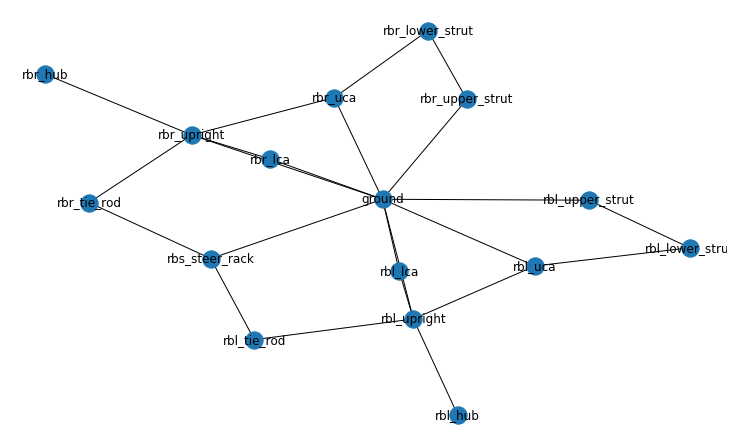

In [12]:
sym_model.topology.draw_constraints_topology()

Checking the system's number of generalized coordinates $n$ and number of constraints $n_c$.

In [13]:
sym_model.topology.n, sym_model.topology.nc 

(112, 112)

### **ASSEMBLING**

This is the last step of the symbolic model building process, where the system starts the assemblage process of the governing equations, which will be used then in the code generation for the numerical simulation, and also can be used for further symbolic manipulations.</br>

*Note: The equations' notations will be discussed in a separate documentation file.*

In [14]:
sym_model.assemble()

---------------------------------------------------------------
---------------------------------------------------------------

## **SYSTEM CONFIGURATION**
---------------------------

In this step we define a symbolic configuration of our symbolic topology. As you may have noticed in the symbolic topology building step, we only cared about the **_topology_**, thats is the system bodies and their connectivity, and we did not care explicitly with how these components are configured in space.</br>

In order to create a valid numerical simulation session, we have to provide the system with its numerical configuration needed, for example, the joints' locations and orientations. The symbolic topology in its raw form will require you to manually enter all these numerical arguments, which can be cumbersome even for smaller systems. This can be checked by checking the configuration inputs of the symbolic configuration as ```sym_config.config.input_nodes```

Here we start by stating the symbolic inputs we wish to use instead of the default inputs set, and then we define the relation between these newly defined arguments and the original ones. 

**_The details of this process will be provided in the documentation._**

In [15]:
# Symbolic configuration name.
config_name = '%s_cfg'%project_name

# Symbolic configuration instance.
sym_config = configuration(config_name, sym_model)

### CONFIGURATION INPUTS

In [16]:
# Adding the desired set of UserInputs
# ====================================

sym_config.add_point.UserInput('ucaf', mirror=True)
sym_config.add_point.UserInput('ucar', mirror=True)
sym_config.add_point.UserInput('ucao', mirror=True)

sym_config.add_point.UserInput('lcaf', mirror=True)
sym_config.add_point.UserInput('lcar', mirror=True)
sym_config.add_point.UserInput('lcao', mirror=True)

sym_config.add_point.UserInput('tro', mirror=True)
sym_config.add_point.UserInput('tri', mirror=True)

sym_config.add_point.UserInput('strut_chassis', mirror=True)
sym_config.add_point.UserInput('strut_arm', mirror=True)
sym_config.add_point.UserInput('strut_mid', mirror=True)

sym_config.add_point.UserInput('wc', mirror=True)
sym_config.add_point.UserInput('wc1', mirror=True)
sym_config.add_point.UserInput('wc2', mirror=True)

sym_config.add_vector.UserInput('x')
sym_config.add_vector.UserInput('y')
sym_config.add_vector.UserInput('z')


### CONFIGURATION RELATIONS

In [17]:
# Defining Relations between original topology inputs
# and our desired UserInputs.
# ===================================================


sym_config.add_point.Centered('strut_mid', ('hpr_strut_chassis', 'hpr_strut_arm'), mirror=True)

# Spherical Joints:
# =================
sym_config.add_relation.Equal_to('pt1_jcr_uca_upright', ('hpr_ucao',), mirror=True)
sym_config.add_relation.Equal_to('ax1_jcr_uca_upright', ('vcs_z',), mirror=True)

sym_config.add_relation.Equal_to('pt1_jcr_lca_upright', ('hpr_lcao',), mirror=True)
sym_config.add_relation.Equal_to('ax1_jcr_lca_upright', ('vcs_z',), mirror=True)

sym_config.add_relation.Equal_to('pt1_jcr_tie_upright', ('hpr_tro',), mirror=True)
sym_config.add_relation.Equal_to('ax1_jcr_tie_upright', ('vcs_z',), mirror=True)

# Upper Control Arm Revolute Joint:
# =================================
sym_config.add_relation.Centered('pt1_jcr_uca_chassis', ('hpr_ucaf','hpr_ucar'), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_uca_chassis', ('hpr_ucaf','hpr_ucar'), mirror=True)

# Lower Control Arm Revolute Joint:
# =================================
sym_config.add_relation.Centered('pt1_jcr_lca_chassis', ('hpr_lcaf','hpr_lcar'), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_lca_chassis', ('hpr_lcaf','hpr_lcar'), mirror=True)

# Wheel Hub Revolute Joint:
# =========================
sym_config.add_relation.Equal_to('pt1_jcr_hub_bearing', ('hpr_wc',), mirror=True)
sym_config.add_relation.Equal_to('ax1_jcr_hub_bearing', ('vcs_y',), mirror=True)

# Strut-Chassis Universal Joint:
# ==============================
sym_config.add_relation.Equal_to('pt1_jcr_strut_chassis', ('hpr_strut_chassis',), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_strut_chassis', ('hpr_strut_chassis','hpr_strut_arm'), mirror=True)
sym_config.add_relation.Oriented('ax2_jcr_strut_chassis', ('hpr_strut_arm','hpr_strut_chassis'), mirror=True)

# Strut-Control-Arm Universal Joint:
# ==================================
sym_config.add_relation.Equal_to('pt1_jcr_strut_uca', ('hpr_strut_arm',), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_strut_uca', ('hpr_strut_chassis','hpr_strut_arm'), mirror=True)
sym_config.add_relation.Oriented('ax2_jcr_strut_uca', ('hpr_strut_arm','hpr_strut_chassis'), mirror=True)

# Tie-Steer Universal Joint:
# ==========================
sym_config.add_relation.Equal_to('pt1_jcr_tie_steering', ('hpr_tri',), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_tie_steering', ('hpr_tri','hpr_tro'), mirror=True)
sym_config.add_relation.Oriented('ax2_jcr_tie_steering', ('hpr_tro','hpr_tri'), mirror=True)

# Strut Cylinderical Joint:
# =========================
sym_config.add_relation.Equal_to('pt1_jcr_strut', ('hpr_strut_mid',), mirror=True)
sym_config.add_relation.Oriented('ax1_jcr_strut', ('hpr_strut_arm','hpr_strut_chassis'), mirror=True)

# Rack Translational Joint:
# =========================
sym_config.add_relation.Centered('pt1_jcs_rack', ('hpr_tri', 'hpl_tri'))
sym_config.add_relation.Oriented('ax1_jcs_rack', ('hpr_tri', 'hpl_tri'))


### GEOMETRIES

Here we start defining basic geometric shapes that can represents the shapes of the bodies in our system. This serves two points:
- Visualization and Animation in blender.
- Evaluating the bodies inertia properties from these basic geometries instead of explicit definition.

In [18]:
# ===================
# Creating Geometries
# ===================
sym_config.add_scalar.UserInput('links_ro')
sym_config.add_scalar.UserInput('strut_outer')
sym_config.add_scalar.UserInput('strut_inner')
sym_config.add_scalar.UserInput('thickness')
sym_config.add_scalar.UserInput('hub_radius')


# Upper Control Arm Geometry.
sym_config.add_geometry.Triangular_Prism('uca', ('hpr_ucaf','hpr_ucar','hpr_ucao','s_thickness'), mirror=True)
sym_config.assign_geometry_to_body('rbr_uca', 'gmr_uca', mirror=True)

# Lower Control Arm Geometry.
sym_config.add_geometry.Triangular_Prism('lca', ('hpr_lcaf','hpr_lcar','hpr_lcao','s_thickness'), mirror=True)
sym_config.assign_geometry_to_body('rbr_lca', 'gmr_lca', mirror=True)

# Upright (Wheel-Carrier) Geometry.
sym_config.add_geometry.Triangular_Prism('upright', ('hpr_ucao','hpr_wc','hpr_lcao','s_thickness'), mirror=True)
sym_config.assign_geometry_to_body('rbr_upright', 'gmr_upright', mirror=True)

# Upper Strut Cylinder Geometry.
sym_config.add_geometry.Cylinder_Geometry('upper_strut', ('hpr_strut_chassis','hpr_strut_mid','s_strut_outer'), mirror=True)
sym_config.assign_geometry_to_body('rbr_upper_strut', 'gmr_upper_strut', mirror=True)

# Lower Strut Cylinder Geometry.
sym_config.add_geometry.Cylinder_Geometry('lower_strut', ('hpr_strut_mid','hpr_strut_arm','s_strut_inner'), mirror=True)
sym_config.assign_geometry_to_body('rbr_lower_strut', 'gmr_lower_strut', mirror=True)

# Tie-Rod Cylinder Geometry.
sym_config.add_geometry.Cylinder_Geometry('tie_rod', ('hpr_tri','hpr_tro','s_links_ro'), mirror=True)
sym_config.assign_geometry_to_body('rbr_tie_rod', 'gmr_tie_rod', mirror=True)

# Tire/Hub Geometry.
sym_config.add_geometry.Cylinder_Geometry('hub', ('hpr_wc1','hpr_wc2','s_hub_radius'), mirror=True)
sym_config.assign_geometry_to_body('rbr_hub', 'gmr_hub', mirror=True)

# Steering Rack Geometry
sym_config.add_geometry.Cylinder_Geometry('steer_rack', ('hpr_tri', 'hpl_tri','s_links_ro'))
sym_config.assign_geometry_to_body('rbs_steer_rack', 'gms_steer_rack')

### ASSEMBLING

In [19]:
sym_config.assemble()

---------------------------------------------------------------
---------------------------------------------------------------

## **CODE GENERATION**
----------------------

This step aims to create a valid code that can be used for numerical simulation. We will use the ***python code generators*** to create a valid numerical simulation environment in python.</br>
Theoretically, the symbolic environment is uncoupled from the simulation environment, which opens the door to create various simulation environments that can be in any language.

### Generating Python Numerical Environment

In [20]:
from smbd.numenv.python.codegen import projects as py_numenv

In [21]:
# Creating the needed directories structure for the source code.
py_project = py_numenv.standalone_project(parent_dir='')
py_project.create_dirs()

In [22]:
# Generating the source code.
py_project.write_topology_code(sym_model.topology)
py_project.write_configuration_code(sym_config.config)

File full path : numenv/python/src/dwb_direct_acting.py
File full path : numenv/python/src/dwb_direct_acting_cfg.py


### Generating Blender Script

In [23]:
from smbd.utilities.blender.codegen import script_generator

In [24]:
bpy_code = script_generator(sym_config.config)
bpy_code.write_code_file('numenv/')

## **PYTHON NUMERICAL SIMULATION**
---------------------------

The **numerical simulation** step is also a straight forward one. We start by importing helper libraries like **numpy** and **pandas**, then we import the ```multibody_system``` class and the ```simulation``` class that will be used to create a numerical system and a simulation instance respectively. And finally we import the generated code files from the previous step.

The steps then can be summarized as follows:
1. Create a numerical model instance by passing the generated topology code to the ```multibody_system``` class.
2. Make the configuration of that instance refers to the generated configuration code.
3. Setting the numerical data of the configuration.
4. Setting the **user-defined functions** that will be used for the actuators/forces.
5. Creating a **simulation instance**, set the desired time-sampling and run the simulation.
6. Plotting the results.

###  Imports

In [25]:
import numpy as np
from smbd.numenv.python.numerics.core.systems import multibody_system, simulation

In [26]:
# Importing the generated modules/souce-code of the model.
from numenv.python.src import dwb_direct_acting, dwb_direct_acting_cfg

### Creating Numerical Model

In [27]:
num_model  = multibody_system(dwb_direct_acting)
num_config = dwb_direct_acting_cfg.configuration()

num_model.topology.config = num_config

### Setting Configuration Numerical Data

In [28]:
# Creating numerical inputs instance.
num_inputs = dwb_direct_acting_cfg.inputs('front_axle')

In [48]:
# Specifying the Numerical Configuration of the System.
# ====================================================
num_inputs.P_ground.flat[:] = [1, 0, 0, 0]

# Tire Radius
TR = 265

# Upper Control Arms
num_inputs.hpr_ucaf.flat[:] = [-127, 350, 142 + TR]
num_inputs.hpr_ucar.flat[:] = [ 103, 350, 128 + TR]
num_inputs.hpr_ucao.flat[:] = [ -12, 589, 127 + TR]

# Lower Control Arms
num_inputs.hpr_lcaf.flat[:] = [-108, 345, -80 + TR]
num_inputs.hpr_lcar.flat[:] = [ 122, 345, -80 + TR]
num_inputs.hpr_lcao.flat[:] = [   7, 620, -89 + TR]

# Tie-Rod
num_inputs.hpr_tri.flat[:] = [-156, 317, 186 + TR]
num_inputs.hpr_tro.flat[:] = [-156, 454, 178 + TR]


# Strut
num_inputs.hpr_strut_chassis.flat[:] = [-15, 500, 540 + TR]
num_inputs.hpr_strut_arm.flat[:]  = [-12, 491, 104 + TR]

# Strut-Force element points' of application and Free-Length
num_inputs.pt1_far_strut = num_inputs.hpr_strut_chassis
num_inputs.pt2_far_strut = num_inputs.hpr_strut_arm
num_inputs.far_strut_FL = 400


# Wheel-Hub
num_inputs.hpr_wc.flat[:]  = [0, 650, 0 + TR]
num_inputs.hpr_wc1.flat[:] = [0, 700, 0 + TR]
num_inputs.hpr_wc2.flat[:] = [0, 600, 0 + TR]

# x, y and z vectors
num_inputs.vcs_x.flat[:] = [1, 0, 0]
num_inputs.vcs_y.flat[:] = [0, 1, 0]
num_inputs.vcs_z.flat[:] = [0, 0, 1]

# Geometry Scalars
num_inputs.s_hub_radius  = TR
num_inputs.s_links_ro    = 8
num_inputs.s_strut_inner = 15
num_inputs.s_strut_outer = 22
num_inputs.s_thickness   = 8

# vertical travel actuation points.
num_inputs.pt1_mcr_wheel_travel.flat[:] = [0, 600, 0]
num_inputs.pt2_mcr_wheel_travel.flat[:] = [0, 600, 0]

# Saving the data to a csv file.
num_inputs.to_csv('config_inputs')

### Setting User Functions.

#### Actuators
Here we set the actuation functions of the system actuators.

In [49]:
# Vertical travel actuation function
num_inputs.UF_mcr_wheel_travel = lambda t : 70*np.sin(t)
num_inputs.UF_mcl_wheel_travel = lambda t : 70*np.sin(t)

# Wheel spin actuation function
num_inputs.UF_mcr_wheel_lock = lambda t : 0
num_inputs.UF_mcl_wheel_lock = lambda t : 0

#### Forces
Here we set the actuation functions of the system forces.

In [50]:
# Creating a coilover class that represents out strut element.
class coilover(object):
    
    def __init__(self, k, c):
        self.k = k * 1e6 # convert from N.mm to (gm.mm/s2).mm
        self.c = c * 1e6 # convert from N.mm/s to (gm.mm/s2).mm/s
        
    def spring_force(self, x):
        force = self.k * x if x>0 else 0
        return force
    
    def damping_force(self, v):
        force = self.c * v
        return force

In [51]:
strut_force = coilover(100, 12)

num_inputs.UF_far_strut_Fs = strut_force.spring_force
num_inputs.UF_far_strut_Fd = strut_force.damping_force

### Assembling the numerical configuration.
Here, we pass the numerical inputs instance ```num_inputs``` to the ```assemble()``` method of the ```num_config``` instance of our model.

In [52]:
num_config.assemble(num_inputs)

### Creating Simulation Instance

A simulation instance takes in three arguments, the simulation ```name```, the numerical ```model``` and the simulation ```typ```. The simulation ```typ``` argument should be either *kds* for kinematically driven systems or *dds* for dynamically driven systems. For our case, the system is kinematically fully constrained, and therefore we will set the ```typ``` as *kds*.

In [54]:
sim = simulation('sim', num_model, 'kds')
sim.set_time_array(2*np.pi, 1e-2)
sim.solve()


Running System Kinematic Analysis:
[=========================] 100%, (628/628) steps. ET = 16.22 (s)



We then save the simulation results if needed.

In [55]:
sim.save_results('results', 'vertical_travel_70mm')

results saved as vertical_travel_70mm.csv at /home/khaledghobashy/Documents/smbd/examples/standalone_models/notebooks/double_wishbone_suspension/results


### Plotting the Results

#### System Configuration Plots

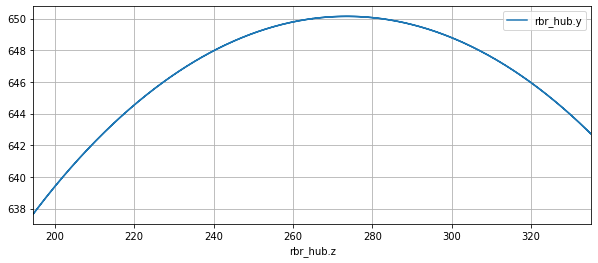

In [56]:
sim.soln.pos_dataframe.plot(x='rbr_hub.z', y='rbr_hub.y', grid=True, figsize=(10,4))


### Evaluating System Reactions

Here we take the simulation a step further and evaluate the reactions resulted due the imposed constraints, either by joints or motion actuators.

In [57]:
sim.eval_reactions()


Evaluating System Constraints' Forces.
[=========================] 100%, (629/629) steps. ET = 8.912 (s)